In [1]:
!pip install -q xgboost==2.1.4
!pip install -q pyswarms mealpy modin jupyter-server-proxy

import os
import logging
import warnings

import modin.pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

logging.getLogger('distributed').setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 55.3 MB/s eta 0:00:00


# Import Data

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Trans.csv")
print(df.columns);
print(df.shape)
df.head()

2025-05-21 14:47:33,476	INFO worker.py:1841 -- Started a local Ray instance.


Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')
(5078345, 11)


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


# Exploratory Data Analysis

In [3]:
df = df.rename(columns={'Is Laundering': 'Is_Laundering'})

In [4]:
df[-5:]

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022/09/10 23:35,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022/09/10 23:52,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0
5078344,2022/09/10 23:37,154518,8148A6091,256398,8148A8711,0.281983,Bitcoin,0.281983,Bitcoin,Bitcoin,0


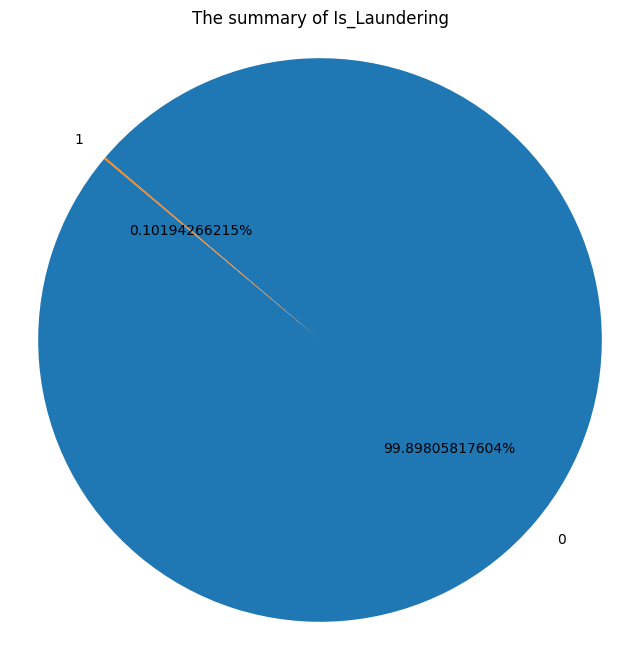

In [5]:
laundering_counts = df['Is_Laundering'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(laundering_counts, labels=laundering_counts.index, autopct='%1.11f%%', startangle=140)
plt.title('The summary of Is_Laundering')
plt.axis('equal')

plt.show()

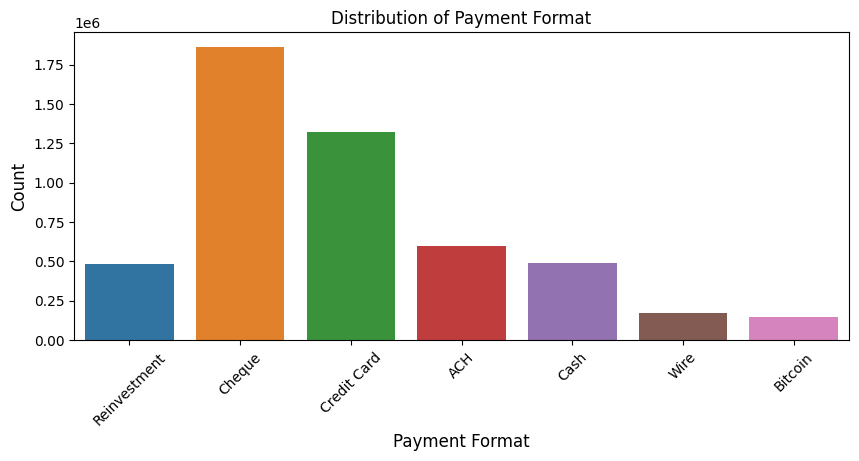

In [6]:
f, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='Payment Format', data=df, ax=ax)
ax.set_title('Distribution of Payment Format')
ax.set_xlabel('Payment Format', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# Set the x-axis tick labels to the original values
# ax.set_xticklabels(df['Payment Format'].unique())

plt.show()

In [7]:
df['Payment Format'].unique()

array(['Reinvestment', 'Cheque', 'Credit Card', 'ACH', 'Cash', 'Wire',
       'Bitcoin'], dtype=object)

The complexity of these payment methods is from least to most:

Cash (Cash) Cash does not require any system or equipment and is the simplest way to complete payment directly.

Check (Cheque) A check only requires a paper check and a bank account. It is simple but needs to wait for settlement.

Automated Clearing House (ACH) ACH requires the establishment of an inter-bank transfer system, which has many steps but is simple to use daily.

Credit Card Credit Card seems simple, but it requires complex systems such as settlement by the card issuer.

Wire transfer (Wire) Wire transfer seems to be a direct transfer, but it involves complex international supervision and settlement processes.

Bitcoin (Bitcoin) The concept of Bitcoin is abstract and needs to deal with many new concepts such as secret keys and transactions.

Reinvestment

In [8]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is_Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [9]:
print(df.shape)
df = df.drop_duplicates(keep = 'first')
df.shape

(5078345, 11)


(5078336, 11)

In [10]:
has_nan = df.isnull().values.any()

if has_nan:
    print("NaN")
    print(df.isnull().sum())
else:
    print("not NaN")

not NaN


In [11]:
df.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is_Laundering
count,5.078336e+06,5.078336e+06,5.078336e+06,5.078336e+06,5.078336e+06
mean,4.573058e+04,6.574461e+04,5.988737e+06,4.509281e+06,1.019428e-03
std,8.176567e+04,8.409303e+04,1.037184e+09,8.697736e+08,3.191221e-02
min,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,9.679000e+03,2.156800e+04,1.411040e+03,1.414570e+03,0.000000e+00
75%,2.862800e+04,1.223320e+05,1.234630e+04,1.229815e+04,0.000000e+00
max,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00


In [12]:
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols

['Timestamp',
 'Account',
 'Account.1',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

In [13]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [14]:
# Select a column of object type
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(object_cols)

# Use Label Encoding to quantify object type columns
label_encoder = LabelEncoder()
for col in object_cols:
    if col != 'Payment Format':
        df[col] = label_encoder.fit_transform(df[col])

# Sort by payment complexity
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Use map method to encode Payment Format column
df['Payment Format'] = df['Payment Format'].map(payment_map)

# Output processed data
df.head()

['Timestamp', 'Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
0,20,10,942,10,900,3697.34,12,3697.34,12,7,0
1,20,3208,990,1,949,0.01,12,0.01,12,2,0
2,0,3209,991,3209,940,14675.57,12,14675.57,12,7,0
3,2,12,997,12,945,2806.97,12,2806.97,12,7,0
4,6,10,999,10,947,36682.97,12,36682.97,12,7,0


## Normalization

In [15]:
# All attributes normalized

# Separate labels from dataset
labels = df['Is_Laundering']
df = df.drop('Is_Laundering', axis=1)

df['Timestamp'] = pd.to_datetime(df['Timestamp']).astype(int) / 10**9

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df_normalized = scaler.transform(df)

# Convert the normalized data to a DataFrame object and set the column names
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)

# Add the label column to the regression-normalized data set
df_normalized['Is_Laundering'] = labels.tolist()

# Output the Normalized data
print(df_normalized.head())

   Timestamp  From Bank   Account   To Bank  Account.1  Amount Received  \
0  -0.997336  -0.999949 -0.996209 -0.999949  -0.995721             -1.0   
1  -0.997336  -0.981998 -0.996016 -1.000000  -0.995488             -1.0   
2  -1.000000  -0.981993 -0.996012 -0.981992  -0.995531             -1.0   
3  -0.999734  -0.999938 -0.995988 -0.999938  -0.995507             -1.0   
4  -0.999201  -0.999949 -0.995980 -0.999949  -0.995497             -1.0   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  \
0            0.714286         -1.0          0.714286        1.000000   
1            0.714286         -1.0          0.714286       -0.666667   
2            0.714286         -1.0          0.714286        1.000000   
3            0.714286         -1.0          0.714286        1.000000   
4            0.714286         -1.0          0.714286        1.000000   

   Is_Laundering  
0              0  
1              0  
2              0  
3              0  
4              0  


In [16]:
# Select the row where the Is_Laundering column is 1
df_laundering = df_normalized.loc[df_normalized['Is_Laundering'] == 1]

# Output selected data
print(df_normalized.count())
df_laundering.count()

Timestamp             5078336
From Bank             5078336
Account               5078336
To Bank               5078336
Account.1             5078336
Amount Received       5078336
Receiving Currency    5078336
Amount Paid           5078336
Payment Currency      5078336
Payment Format        5078336
Is_Laundering         5078336
dtype: int64


Timestamp             5177
From Bank             5177
Account               5177
To Bank               5177
Account.1             5177
Amount Received       5177
Receiving Currency    5177
Amount Paid           5177
Payment Currency      5177
Payment Format        5177
Is_Laundering         5177
dtype: int64

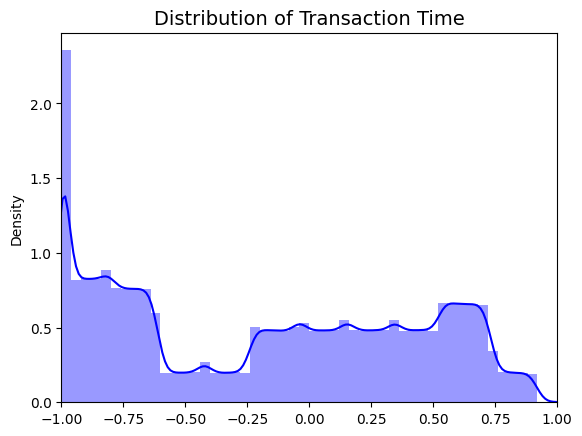

In [17]:
time_val = df_normalized['Timestamp'].values
sns.distplot(time_val, color='b')
plt.title('Distribution of Transaction Time', fontsize=14)
plt.xlim([min(time_val), max(time_val)])

plt.show()

In [18]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df_normalized = df_normalized.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 1]
non_fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
1544475,-0.701272,-0.998810,0.219966,-0.815809,0.236231,-1.0,-0.285714,-1.0,-0.285714,-0.666667,0
4103824,0.487248,-0.849235,-0.466159,-0.867789,0.339927,-1.0,-0.428571,-1.0,-0.428571,-0.666667,0
2248703,0.016981,-0.876167,-0.141901,-0.875642,-0.138303,-1.0,0.571429,-1.0,0.571429,-0.333333,1
3133020,0.860158,-0.999388,0.271243,-0.999944,-0.944755,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
695468,0.281747,-0.998821,-0.117378,-0.974616,-0.158287,-1.0,0.714286,-1.0,0.714286,-0.333333,1


Distribution of the Is_Launderinges in the subsample dataset
Is_Laundering
0    0.5
1    0.5
Name: count, dtype: float64


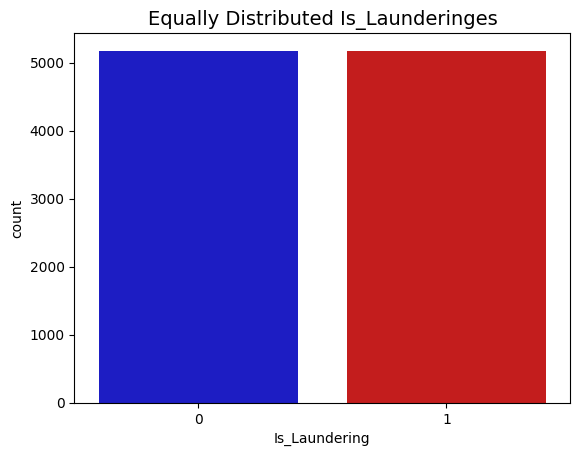

In [19]:
print('Distribution of the Is_Launderinges in the subsample dataset')
print(new_df['Is_Laundering'].value_counts()/len(new_df))

colors = ["#0101DF", "#DF0101"]
sns.countplot(data=new_df, x='Is_Laundering', palette=colors)
plt.title('Equally Distributed Is_Launderinges', fontsize=14)
plt.show()

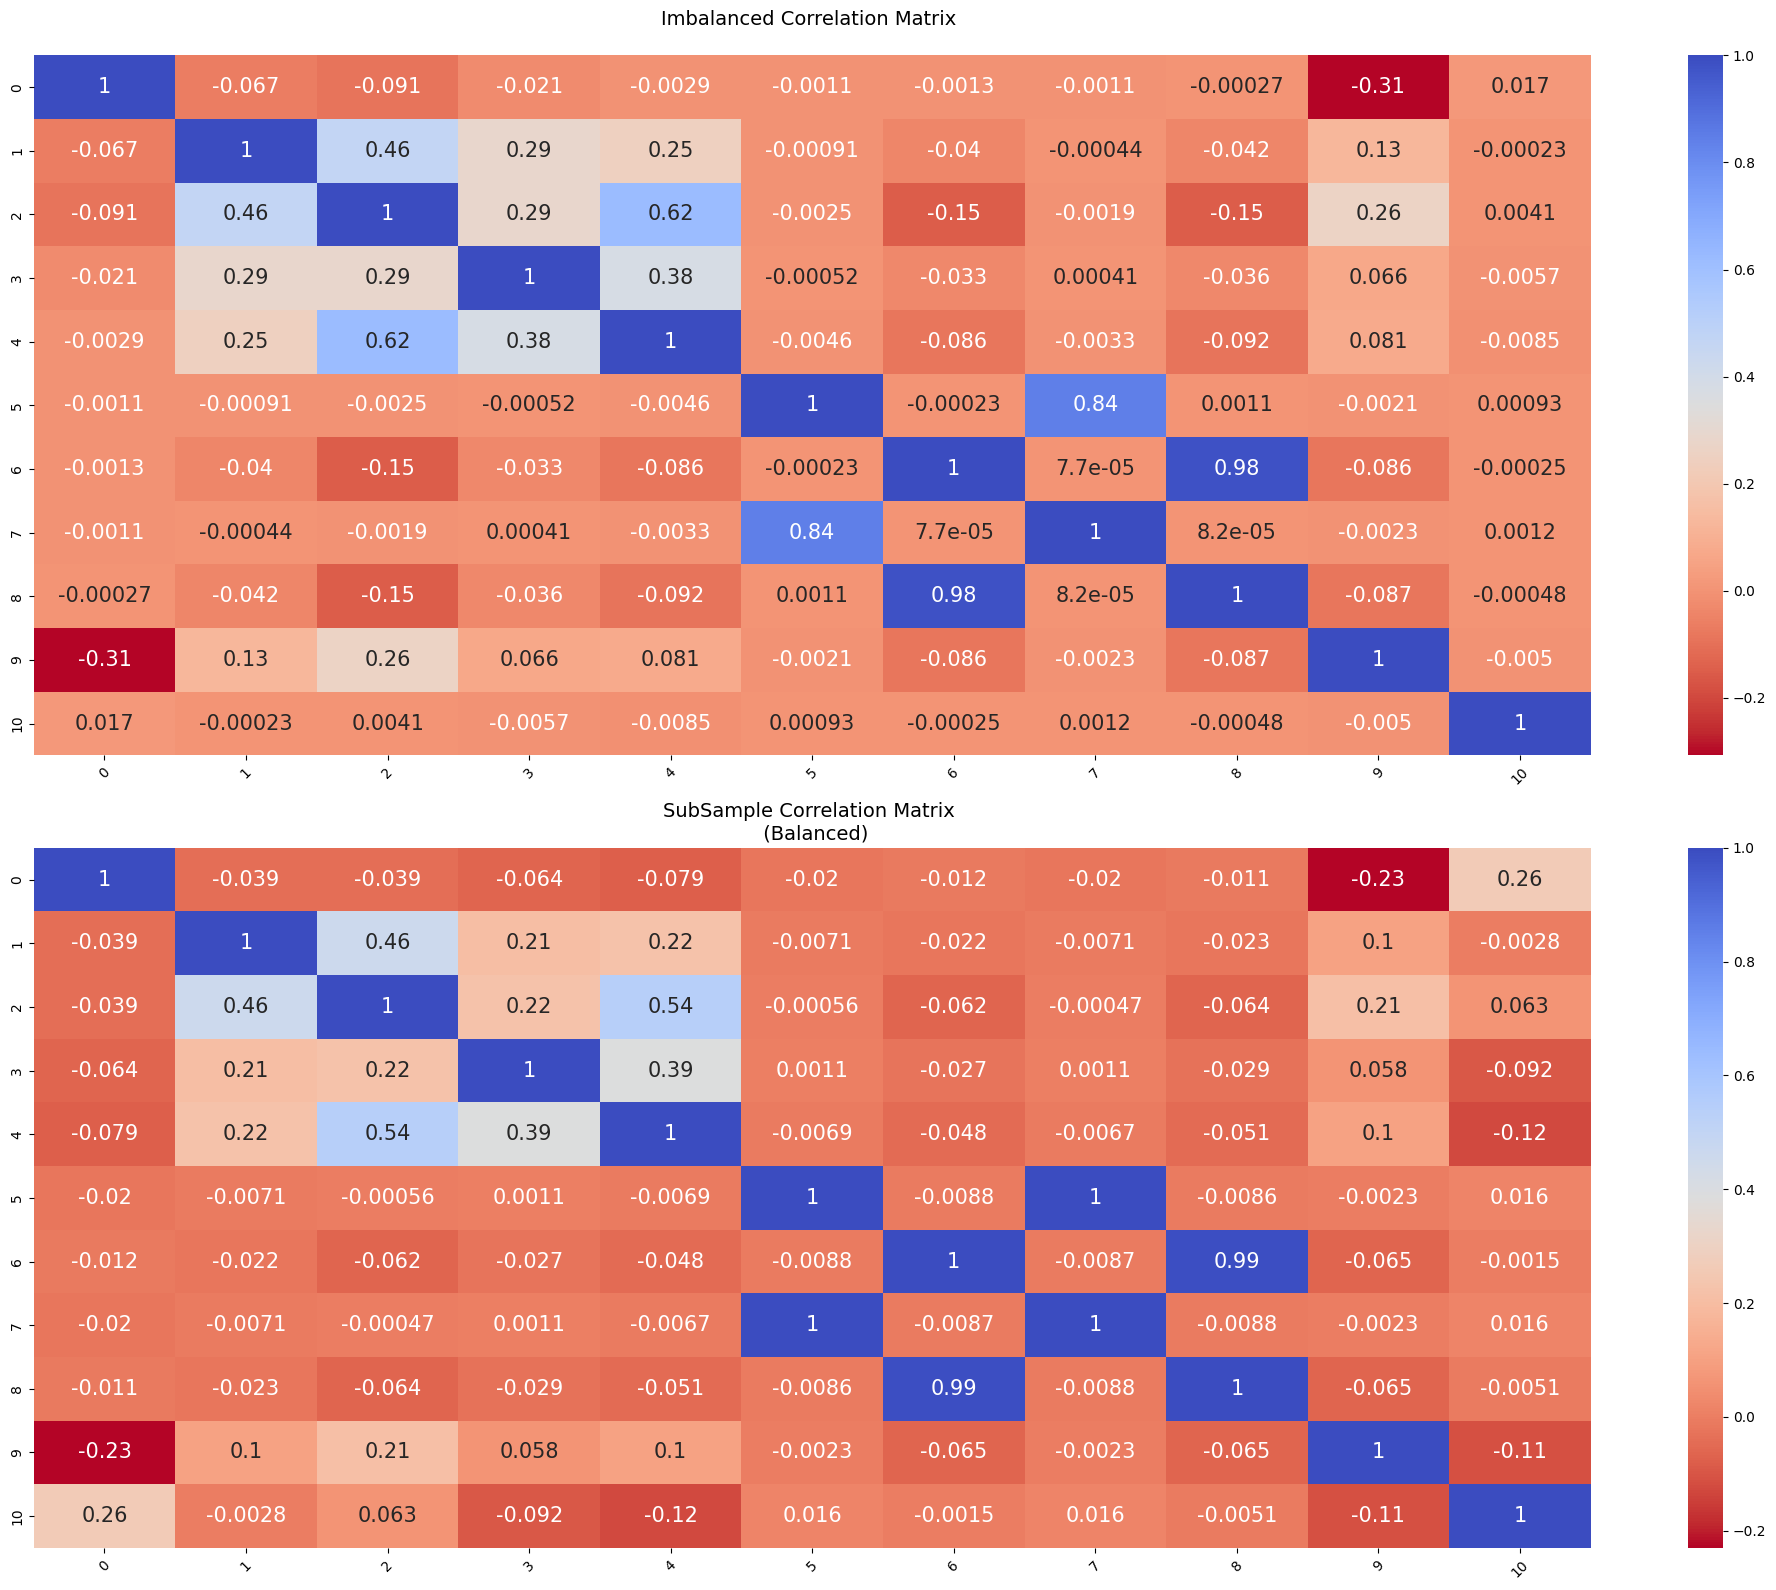

In [20]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,16))

# Entire DataFrame
corr = df_normalized.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n ", fontsize=14)
ax1.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# Undersampled dataset
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (Balanced)', fontsize=14)
ax2.tick_params(axis='x', labelrotation=45) # rotate x-axis labels
plt.tight_layout()
plt.show()

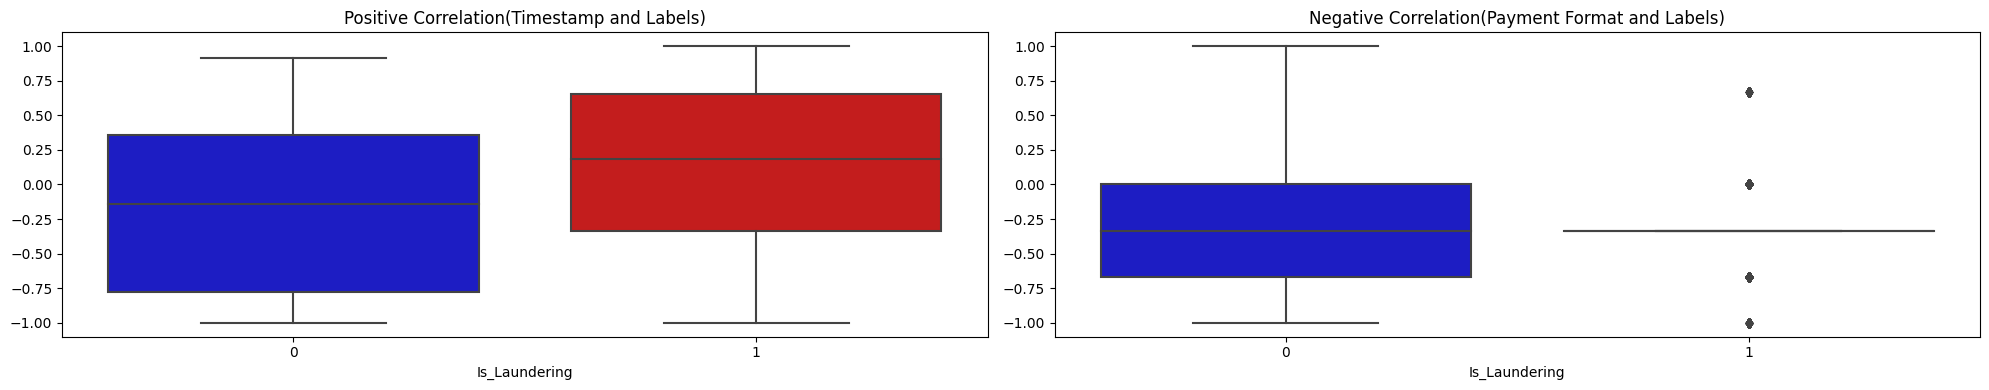

In [21]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Positive Correlation(Timestamp and Labels)')

sns.boxplot(x="Is_Laundering", y="Payment Format", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Negative Correlation(Payment Format and Labels)')

plt.tight_layout()
plt.show()

In [22]:
fig1 = px.scatter(new_df, x="Timestamp", y="Is_Laundering")
fig2 = px.scatter(new_df, x="Payment Format", y="Is_Laundering")
fig1.show()
fig2.show()

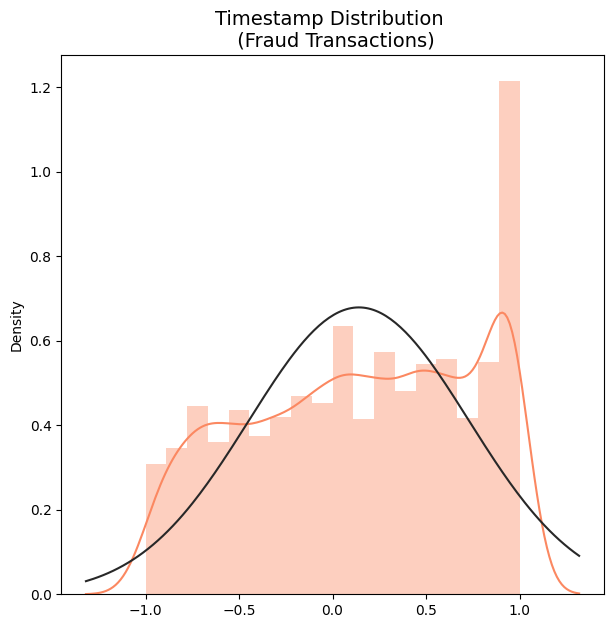

In [23]:
from scipy.stats import norm

f, ax = plt.subplots(figsize=(7, 7))

Timestamp_fraud_dist = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')
ax.set_title('Timestamp Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [24]:
Timestamp_fraud = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
q25, q75 = np.percentile(Timestamp_fraud, 25), np.percentile(Timestamp_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
Timestamp_iqr = q75 - q25
print('iqr: {}'.format(Timestamp_iqr))

Timestamp_cut_off = Timestamp_iqr * 1.5
Timestamp_lower, Timestamp_upper = q25 - Timestamp_cut_off, q75 + Timestamp_cut_off
print('Cut Off: {}'.format(Timestamp_cut_off))
print('Timestamp Lower: {}'.format(Timestamp_lower))
print('Timestamp Upper: {}'.format(Timestamp_upper))

outliers = [x for x in Timestamp_fraud if x < Timestamp_lower or x > Timestamp_upper]
print('Feature Timestamp Outliers for Fraud Cases: {}'.format(len(outliers)))
print('Timestamp outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['Timestamp'] > Timestamp_upper) | (new_df['Timestamp'] < Timestamp_lower)].index)

new_df.head()

Quartile 25: -0.3367516814277153 | Quartile 75: 0.6555903309582474
iqr: 0.9923420123859626
Cut Off: 1.488513018578944
Timestamp Lower: -1.825264700006659
Timestamp Upper: 2.1441033495371915
Feature Timestamp Outliers for Fraud Cases: 0
Timestamp outliers:[]


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
1544475,-0.701272,-0.998810,0.219966,-0.815809,0.236231,-1.0,-0.285714,-1.0,-0.285714,-0.666667,0
4103824,0.487248,-0.849235,-0.466159,-0.867789,0.339927,-1.0,-0.428571,-1.0,-0.428571,-0.666667,0
2248703,0.016981,-0.876167,-0.141901,-0.875642,-0.138303,-1.0,0.571429,-1.0,0.571429,-0.333333,1
3133020,0.860158,-0.999388,0.271243,-0.999944,-0.944755,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
695468,0.281747,-0.998821,-0.117378,-0.974616,-0.158287,-1.0,0.714286,-1.0,0.714286,-0.333333,1


Text(0.5, 0.25, 'Fewer extreme \n outliers')

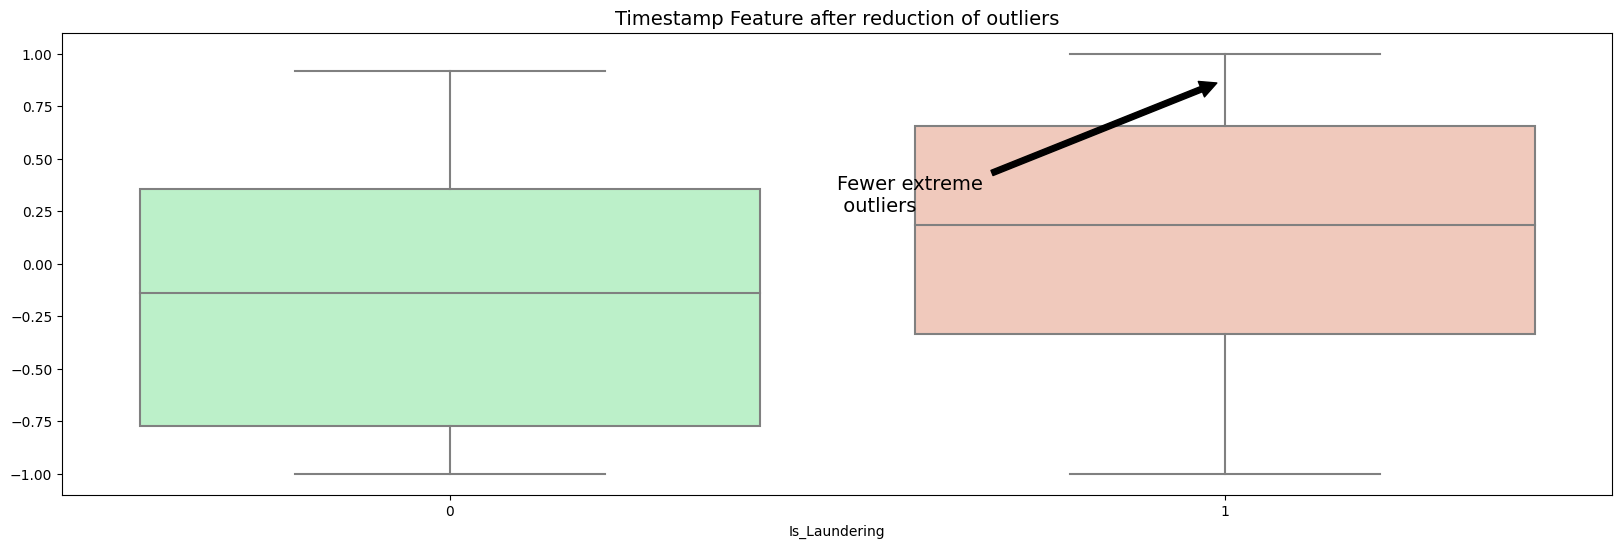

In [25]:
f,ax1 = plt.subplots(figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df,ax=ax1, palette=colors)
ax1.set_title("Timestamp Feature after reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.99, 0.86), xytext=(0.5, 0.25),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

In [26]:
new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
1544475,-0.701272,-0.998810,0.219966,-0.815809,0.236231,-1.0,-0.285714,-1.0,-0.285714,-0.666667,0
4103824,0.487248,-0.849235,-0.466159,-0.867789,0.339927,-1.0,-0.428571,-1.0,-0.428571,-0.666667,0
2248703,0.016981,-0.876167,-0.141901,-0.875642,-0.138303,-1.0,0.571429,-1.0,0.571429,-0.333333,1
3133020,0.860158,-0.999388,0.271243,-0.999944,-0.944755,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
695468,0.281747,-0.998821,-0.117378,-0.974616,-0.158287,-1.0,0.714286,-1.0,0.714286,-0.333333,1


# XGBoost Model

[0]	train-logloss:0.51089	train-error:0.09538	test-logloss:0.51839	test-error:0.10768
[100]	train-logloss:0.08047	train-error:0.01678	test-logloss:0.24841	test-error:0.10961
[200]	train-logloss:0.03871	train-error:0.00048	test-logloss:0.27737	test-error:0.11444
[300]	train-logloss:0.02260	train-error:0.00000	test-logloss:0.30424	test-error:0.11540
[400]	train-logloss:0.01542	train-error:0.00000	test-logloss:0.32604	test-error:0.11492
[500]	train-logloss:0.01115	train-error:0.00000	test-logloss:0.34530	test-error:0.11492
[600]	train-logloss:0.00862	train-error:0.00000	test-logloss:0.36314	test-error:0.11540
[700]	train-logloss:0.00707	train-error:0.00000	test-logloss:0.37773	test-error:0.11637
[800]	train-logloss:0.00592	train-error:0.00000	test-logloss:0.39192	test-error:0.11975
[900]	train-logloss:0.00512	train-error:0.00000	test-logloss:0.40188	test-error:0.12023
[999]	train-logloss:0.00451	train-error:0.00000	test-logloss:0.41138	test-error:0.12071


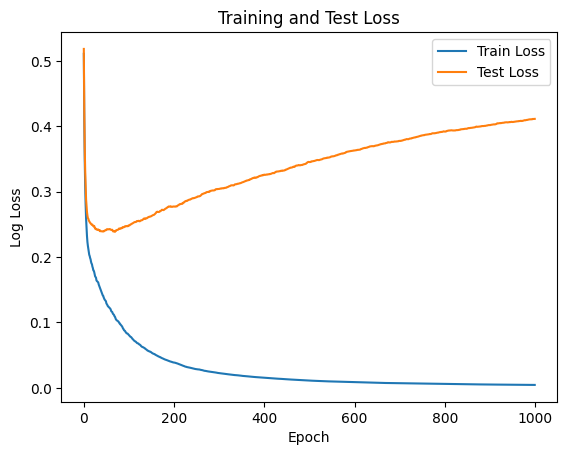

In [27]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

# Split the dataset into features and target variable
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.3,
    'max_depth': 6,
    'subsample': 1,
    'colsample_bytree': 1,
    'alpha': 0,
    'lambda': 1,
    'device': 'cuda',
    'tree_method': 'hist'  # Enables GPU training
}

# Train the XGBoost model and record the evaluation results
num_rounds = 1000
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results, verbose_eval=100)

# Evaluate the XGBoost model with multiple metrics
y_pred = bst.predict(dtest)
y_pred_binary = np.round(y_pred)  # For metrics requiring binary predictions (F1, precision, recall)
y_pred_proba = y_pred  # For AUC ROC which uses probabilities

# Extract the training and test loss from the evaluation results
train_loss = eval_results['train']['logloss']
test_loss = eval_results['test']['logloss']

# Plot the training and test loss curves
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.ylabel('Log Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [28]:
y_pred_train = bst.predict(dtrain)
y_pred_train_binary = np.round(y_pred_train)  # For binary metrics
y_pred_train_proba = y_pred_train  # For AUC ROC

# Compute training metrics
train_accuracy = accuracy_score(y_train, y_pred_train_binary)
train_f1 = f1_score(y_train, y_pred_train_binary)
train_auc = roc_auc_score(y_train, y_pred_train_proba)
train_precision = precision_score(y_train, y_pred_train_binary)
train_recall = recall_score(y_train, y_pred_train_binary)
# Compute all metrics
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)

# Print training metrics
print("XGBoost Training Metrics:")
print("Accuracy:", round(train_accuracy * 100, 2), "%")
print("F1 Score:", round(train_f1 * 100, 2), "%")
print("AUC ROC:", round(train_auc * 100, 2), "%")
print("Precision:", round(train_precision * 100, 2), "%")
print("Recall:", round(train_recall * 100, 2), "%")


# Print all metrics
print("\nXGBoost Testing Metrics:")
print("Accuracy:", round(test_accuracy * 100, 2), "%")
print("F1 Score:", round(test_f1 * 100, 2), "%")
print("AUC ROC:", round(test_auc * 100, 2), "%")
print("Precision:", round(test_precision * 100, 2), "%")
print("Recall:", round(test_recall * 100, 2), "%")

# Print differences between training and test metrics
print("\nDifferences (Training - Test):")
print("Accuracy Difference:", round((train_accuracy - test_accuracy) * 100, 2), "%")
print("F1 Score Difference:", round((train_f1 - test_f1) * 100, 2), "%")
print("AUC ROC Difference:", round((train_auc - test_auc) * 100, 2), "%")
print("Precision Difference:", round((train_precision - test_precision) * 100, 2), "%")
print("Recall Difference:", round((train_recall - test_recall) * 100, 2), "%")


XGBoost Training Metrics:
Accuracy: 100.0 %
F1 Score: 100.0 %
AUC ROC: 100.0 %
Precision: 100.0 %
Recall: 100.0 %

XGBoost Testing Metrics:
Accuracy: 87.93 %
F1 Score: 88.22 %
AUC ROC: 95.59 %
Precision: 86.75 %
Recall: 89.74 %

Differences (Training - Test):
Accuracy Difference: 12.07 %
F1 Score Difference: 11.78 %
AUC ROC Difference: 4.41 %
Precision Difference: 13.25 %
Recall Difference: 10.26 %


# Particle Swarm Optimization

In [29]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score
import pyswarms as ps

import time
start_time = time.time()

# Define the objective function for PSO (optimizing negative F1 score)
def pso_objective(X):
    f1_scores = []
    for x in X:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'eta': x[0],
            'max_depth': int(max(3, x[1])),  # Ensure at least depth of 3
            'subsample': x[2],
            'colsample_bytree': x[3],
            'alpha': x[4],
            'lambda': x[5],
            'device': 'cuda',
            'tree_method': 'hist',  # Enables GPU training
        }

        # Train XGBoost model with current parameters
        bst_pso = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], verbose_eval=False)

        # Predict on test set and compute F1 score
        y_pred = np.round(bst_pso.predict(dtest))

        # Prevent NaN scores (bad hyperparameters)
        if np.isnan(y_pred).any():
            f1_scores.append(1e6)  # Large penalty for bad models
        else:
            f1_scores.append(-f1_score(y_test, y_pred))  # Negative for minimization

    return np.array(f1_scores)

# Define the search space (lower and upper bounds for each parameter)
lb = [0.01, 3, 0.5, 0.5, 0.0, 0.0]  # [eta, max_depth, subsample, colsample_bytree, alpha, lambda]
ub = [0.3, 20, 1.0, 1.0, 10.0, 10.0]
bounds = (np.array(lb), np.array(ub))

# Set up PSO optimizer
options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}

# Run PSO optimization
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=6, options=options, bounds=bounds)
best_score, best_pso_params = optimizer.optimize(pso_objective, iters=100)

# Train the final model with the best parameters
optimized_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best_pso_params[0],
    'max_depth': int(best_pso_params[1]),
    'subsample': best_pso_params[2],
    'colsample_bytree': best_pso_params[3],
    'alpha': best_pso_params[4],
    'lambda': best_pso_params[5],
    'device': 'cuda',
    'tree_method': 'hist'
}

bst_optimized = xgb.train(optimized_params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], verbose_eval=False)

# Predict on test set
y_pred_pso_test = bst_optimized.predict(dtest)
y_pred_pso_binary_test = np.round(y_pred_pso_test)
y_pred_pso_proba_test = y_pred_pso_test

# Compute test metrics
pso_test_accuracy = accuracy_score(y_test, y_pred_pso_binary_test)
pso_test_f1 = f1_score(y_test, y_pred_pso_binary_test)
pso_test_auc = roc_auc_score(y_test, y_pred_pso_proba_test)
pso_test_precision = precision_score(y_test, y_pred_pso_binary_test)
pso_test_recall = recall_score(y_test, y_pred_pso_binary_test)

# Predict on train set
y_pred_pso_train = bst_optimized.predict(dtrain)
y_pred_pso_binary_train = np.round(y_pred_pso_train)
y_pred_pso_proba_train = y_pred_pso_train

# Compute training metrics
pso_train_accuracy = accuracy_score(y_train, y_pred_pso_binary_train)
pso_train_f1 = f1_score(y_train, y_pred_pso_binary_train)
pso_train_auc = roc_auc_score(y_train, y_pred_pso_proba_train)
pso_train_precision = precision_score(y_train, y_pred_pso_binary_train)
pso_train_recall = recall_score(y_train, y_pred_pso_binary_train)

end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")

# Print optimized model metrics
print("\nBest Parameters from PSO:", {
    'eta': best_pso_params[0],
    'max_depth': int(best_pso_params[1]),
    'subsample': best_pso_params[2],
    'colsample_bytree': best_pso_params[3],
    'alpha': best_pso_params[4],
    'lambda': best_pso_params[5]
})

print("\nPSO Optimized Training Metrics:")
print("Accuracy:", round(pso_train_accuracy * 100, 2), "%")
print("F1 Score:", round(pso_train_f1 * 100, 2), "%")
print("AUC ROC:", round(pso_train_auc * 100, 2), "%")
print("Precision:", round(pso_train_precision * 100, 2), "%")
print("Recall:", round(pso_train_recall * 100, 2), "%")

# Print differences between PSO optimized and original train metrics
print("\nDifferences (PSO Optimized - Original Train):")
print("Accuracy Difference:", round((pso_train_accuracy - train_accuracy) * 100, 2), "%")
print("F1 Score Difference:", round((pso_train_f1 - train_f1) * 100, 2), "%")
print("AUC ROC Difference:", round((pso_train_auc - train_auc) * 100, 2), "%")
print("Precision Difference:", round((pso_train_precision - train_precision) * 100, 2), "%")
print("Recall Difference:", round((pso_train_recall - train_recall) * 100, 2), "%")

print("\nPSO Optimized Testing Metrics:")
print("Accuracy:", round(pso_test_accuracy * 100, 2), "%")
print("F1 Score:", round(pso_test_f1 * 100, 2), "%")
print("AUC ROC:", round(pso_test_auc * 100, 2), "%")
print("Precision:", round(pso_test_precision * 100, 2), "%")
print("Recall:", round(pso_test_recall * 100, 2), "%")

# Print differences between PSO optimized and original test metrics
print("\nDifferences (PSO Optimized - Original Test):")
print("Accuracy Difference:", round((pso_test_accuracy - test_accuracy) * 100, 2), "%")
print("F1 Score Difference:", round((pso_test_f1 - test_f1) * 100, 2), "%")
print("AUC ROC Difference:", round((pso_test_auc - test_auc) * 100, 2), "%")
print("Precision Difference:", round((pso_test_precision - test_precision) * 100, 2), "%")
print("Recall Difference:", round((pso_test_recall - test_recall) * 100, 2), "%")

2025-05-21 14:49:24,929 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-0.905
2025-05-21 15:14:07,191 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9046979865771813, best pos: [0.13670644 3.95580932 0.92645114 0.71453243 5.28522113 2.85548336]



Total time taken: 1482.50 seconds

Best Parameters from PSO: {'eta': 0.13670643587962922, 'max_depth': 3, 'subsample': 0.9264511416313989, 'colsample_bytree': 0.7145324338469433, 'alpha': 5.285221132871294, 'lambda': 2.85548336446422}

PSO Optimized Training Metrics:
Accuracy: 90.16 %
F1 Score: 90.79 %
AUC ROC: 96.73 %
Precision: 85.17 %
Recall: 97.22 %

Differences (PSO Optimized - Original Train):
Accuracy Difference: -9.84 %
F1 Score Difference: -9.21 %
AUC ROC Difference: -3.27 %
Precision Difference: -14.83 %
Recall Difference: -2.78 %

PSO Optimized Testing Metrics:
Accuracy: 89.72 %
F1 Score: 90.47 %
AUC ROC: 95.51 %
Precision: 84.82 %
Recall: 96.93 %

Differences (PSO Optimized - Original Test):
Accuracy Difference: 1.79 %
F1 Score Difference: 2.25 %
AUC ROC Difference: -0.08 %
Precision Difference: -1.93 %
Recall Difference: 7.19 %


# Grey Wolf Optimization

In [30]:
from mealpy import FloatVar, GWO

import time
start_time = time.time()

# Define objective function for Grey Wolf Optimizer Algorithm
def gwo_objective(solution):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': solution[0],
        'max_depth': int(solution[1]),
        'subsample': solution[2],
        'colsample_bytree': solution[3],
        'alpha': solution[4],
        'lambda': solution[5],
        'device': 'cuda',
        'tree_method': 'hist'  # Enable GPU training
    }
    bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, "test")], verbose_eval=False)
    y_pred = np.round(bst.predict(dtest))
    return -f1_score(y_test, y_pred)  # Minimize negative F1 score

# Define search space
problem_dict = {
    "obj_func": gwo_objective,
    "bounds": FloatVar(lb=[0.01, 3, 0.5, 0.5, 0.0, 0.0], ub=[0.3, 20, 1.0, 1.0, 10.0, 10.0]),
    "minmax": "min",
}

# Run GWO Algorithm
gwo = GWO.OriginalGWO(epoch=100, pop_size=50)  # 100 iterations, 50 wolfs
best_agent = gwo.solve(problem_dict)  # Returns an Agent object
best_gwo_params = best_agent.solution  # Extract best solution from the agent

# Train with optimized parameters
gwo_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best_gwo_params[0],
    'max_depth': int(best_gwo_params[1]),
    'subsample': best_gwo_params[2],
    'colsample_bytree': best_gwo_params[3],
    'alpha': best_gwo_params[4],
    'lambda': best_gwo_params[5],
    'device': 'cuda',
    'tree_method': 'hist' # Enable GPU training
}
bst_gwo = xgb.train(gwo_params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], verbose_eval=False)

# Predict on train data
y_pred_gwo_train = bst_gwo.predict(dtrain)
y_pred_gwo_train_binary = np.round(y_pred_gwo_train)

# Evaluate GWO model on training set
gwo_train_accuracy = accuracy_score(y_train, y_pred_gwo_train_binary)
gwo_train_f1 = f1_score(y_train, y_pred_gwo_train_binary)
gwo_train_auc = roc_auc_score(y_train, y_pred_gwo_train)
gwo_train_precision = precision_score(y_train, y_pred_gwo_train_binary)
gwo_train_recall = recall_score(y_train, y_pred_gwo_train_binary)

# Evaluate GWO model on test data
y_pred_gwo = bst_gwo.predict(dtest)
y_pred_gwo_binary = np.round(y_pred_gwo)
gwo_test_accuracy = accuracy_score(y_test, y_pred_gwo_binary)
gwo_test_f1 = f1_score(y_test, y_pred_gwo_binary)
gwo_test_auc = roc_auc_score(y_test, y_pred_gwo_binary)
gwo_test_precision = precision_score(y_test, y_pred_gwo_binary)
gwo_test_recall = recall_score(y_test, y_pred_gwo_binary)

end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")

# Print optimized model metrics
print("\nBest Parameters from Grey Wolf Optimizer Algorithm:", {
    'eta': best_gwo_params[0],
    'max_depth': int(best_gwo_params[1]),
    'subsample': best_gwo_params[2],
    'colsample_bytree': best_gwo_params[3],
    'alpha': best_gwo_params[4],
    'lambda': best_gwo_params[5]
})

print("\nGWO Training Metrics:")
print("Accuracy:", round(gwo_train_accuracy * 100, 2), "%")
print("F1 Score:", round(gwo_train_f1 * 100, 2), "%")
print("AUC ROC:", round(gwo_train_auc * 100, 2), "%")
print("Precision:", round(gwo_train_precision * 100, 2), "%")
print("Recall:", round(gwo_train_recall * 100, 2), "%")

print("\nGWO Testing Metrics:")
print("Accuracy:", round(gwo_test_accuracy * 100, 2), "%")
print("F1 Score:", round(gwo_test_f1 * 100, 2), "%")
print("AUC ROC:", round(gwo_test_auc * 100, 2), "%")
print("Precision:", round(gwo_test_precision * 100, 2), "%")
print("Recall:", round(gwo_test_recall * 100, 2), "%")

2025-05-21 15:14:07,902 - mealpy.swarm_based.GWO.OriginalGWO - INFO - Solving single objective optimization problem.
2025-05-21 15:14:34,802 - mealpy.swarm_based.GWO.OriginalGWO - INFO - >>>Problem: P, Epoch: 1, Current best: -0.9015730337078652, Global best: -0.9015730337078652, Runtime: 10.51958 seconds
2025-05-21 15:14:44,490 - mealpy.swarm_based.GWO.OriginalGWO - INFO - >>>Problem: P, Epoch: 2, Current best: -0.9031690140845071, Global best: -0.9031690140845071, Runtime: 9.68687 seconds
2025-05-21 15:14:54,075 - mealpy.swarm_based.GWO.OriginalGWO - INFO - >>>Problem: P, Epoch: 3, Current best: -0.9031690140845071, Global best: -0.9031690140845071, Runtime: 9.58349 seconds
2025-05-21 15:15:03,762 - mealpy.swarm_based.GWO.OriginalGWO - INFO - >>>Problem: P, Epoch: 4, Current best: -0.9031690140845071, Global best: -0.9031690140845071, Runtime: 9.68541 seconds
2025-05-21 15:15:12,988 - mealpy.swarm_based.GWO.OriginalGWO - INFO - >>>Problem: P, Epoch: 5, Current best: -0.90316901408450


Total time taken: 894.80 seconds

Best Parameters from Grey Wolf Optimizer Algorithm: {'eta': 0.014506650399424928, 'max_depth': 4, 'subsample': 1.0, 'colsample_bytree': 1.0, 'alpha': 1.4259612624279983, 'lambda': 0.18500214263796053}

GWO Training Metrics:
Accuracy: 89.69 %
F1 Score: 90.54 %
AUC ROC: 95.43 %
Precision: 83.52 %
Recall: 98.84 %

GWO Testing Metrics:
Accuracy: 89.47 %
F1 Score: 90.41 %
AUC ROC: 89.41 %
Precision: 83.51 %
Recall: 98.56 %


# Artificial Bee Colony Optimization

In [31]:
from mealpy import FloatVar, ABC

import time
start_time = time.time()

# Define objective function for ABC
def abc_objective(solution):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': solution[0],
        'max_depth': int(solution[1]),
        'subsample': solution[2],
        'colsample_bytree': solution[3],
        'alpha': solution[4],
        'lambda': solution[5],
        'device': 'cuda',
        'tree_method': 'hist'  # Enable GPU acceleration
    }
    bst = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, "test")], verbose_eval=False)
    y_pred = np.round(bst.predict(dtest))
    return -f1_score(y_test, y_pred)  # Minimize negative F1 score

# Define search space
problem_dict = {
    "obj_func": abc_objective,
    "bounds": FloatVar(lb=[0.01, 3, 0.5, 0.5, 0.0, 0.0], ub=[0.3, 20, 1.0, 1.0, 10.0, 10.0]),
    "minmax": "min",
}

# Run ABC
abc = ABC.OriginalABC(epoch=100, pop_size=50)  # 100 iterations, 50 bees
best_agent = abc.solve(problem_dict)  # Returns an Agent object
best_abc_params = best_agent.solution  # Extract best solution from the agent

# Train with optimized parameters
abc_params = {
    'objective': 'binary:logistic', 'eval_metric': 'logloss',
    'eta': best_abc_params[0], 'max_depth': int(best_abc_params[1]),
    'subsample': best_abc_params[2], 'colsample_bytree': best_abc_params[3],
    'alpha': best_abc_params[4], 'lambda': best_abc_params[5],
    'device': 'cuda',
    'tree_method': 'hist'  # Enable GPU acceleration
}
bst_abc = xgb.train(abc_params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], verbose_eval=False)

# Evaluate ABC model
y_pred_abc = bst_abc.predict(dtest)
y_pred_abc_binary = np.round(y_pred_abc)
abc_test_accuracy = accuracy_score(y_test, y_pred_abc_binary)
abc_test_f1 = f1_score(y_test, y_pred_abc_binary)
abc_test_auc = roc_auc_score(y_test, y_pred_abc)
abc_test_precision = precision_score(y_test, y_pred_abc_binary)
abc_test_recall = recall_score(y_test, y_pred_abc_binary)

# Predict on train data
y_pred_abc_train = bst_abc.predict(dtrain)
y_pred_abc_train_binary = np.round(y_pred_abc_train)

# Evaluate ABC model on training set
abc_train_accuracy = accuracy_score(y_train, y_pred_abc_train_binary)
abc_train_f1 = f1_score(y_train, y_pred_abc_train_binary)
abc_train_auc = roc_auc_score(y_train, y_pred_abc_train)
abc_train_precision = precision_score(y_train, y_pred_abc_train_binary)
abc_train_recall = recall_score(y_train, y_pred_abc_train_binary)

end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")

# Print optimized model metrics
print("\nBest Parameters from Artificial Bee Colony:", {
    'eta': best_abc_params[0],
    'max_depth': int(best_abc_params[1]),
    'subsample': best_abc_params[2],
    'colsample_bytree': best_abc_params[3],
    'alpha': best_abc_params[4],
    'lambda': best_abc_params[5]
})

print("\nABC Training Metrics:")
print("Accuracy:", round(abc_train_accuracy * 100, 2), "%")
print("F1 Score:", round(abc_train_f1 * 100, 2), "%")
print("AUC ROC:", round(abc_train_auc * 100, 2), "%")
print("Precision:", round(abc_train_precision * 100, 2), "%")
print("Recall:", round(abc_train_recall * 100, 2), "%")

print("\nABC Testing Metrics:")
print("Accuracy:", round(abc_test_accuracy * 100, 2), "%")
print("F1 Score:", round(abc_test_f1 * 100, 2), "%")
print("AUC ROC:", round(abc_test_auc * 100, 2), "%")
print("Precision:", round(abc_test_precision * 100, 2), "%")
print("Recall:", round(abc_test_recall * 100, 2), "%")

2025-05-21 15:29:05,430 - mealpy.swarm_based.ABC.OriginalABC - INFO - Solving single objective optimization problem.
2025-05-21 15:35:44,212 - mealpy.swarm_based.ABC.OriginalABC - INFO - >>>Problem: P, Epoch: 1, Current best: -0.9011576135351737, Global best: -0.9011576135351737, Runtime: 262.48490 seconds
2025-05-21 15:39:54,263 - mealpy.swarm_based.ABC.OriginalABC - INFO - >>>Problem: P, Epoch: 2, Current best: -0.9023841655420602, Global best: -0.9023841655420602, Runtime: 250.04979 seconds
2025-05-21 15:43:48,370 - mealpy.swarm_based.ABC.OriginalABC - INFO - >>>Problem: P, Epoch: 3, Current best: -0.9023841655420602, Global best: -0.9023841655420602, Runtime: 234.10529 seconds
2025-05-21 15:47:36,166 - mealpy.swarm_based.ABC.OriginalABC - INFO - >>>Problem: P, Epoch: 4, Current best: -0.9023841655420602, Global best: -0.9023841655420602, Runtime: 227.79451 seconds
2025-05-21 15:51:12,395 - mealpy.swarm_based.ABC.OriginalABC - INFO - >>>Problem: P, Epoch: 5, Current best: -0.9023841


Total time taken: 17892.59 seconds

Best Parameters from Artificial Bee Colony: {'eta': 0.3, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 0.9967361671490801, 'alpha': 9.247854120554111, 'lambda': 0.8100827939675375}

ABC Training Metrics:
Accuracy: 90.58 %
F1 Score: 91.16 %
AUC ROC: 97.01 %
Precision: 85.79 %
Recall: 97.24 %

ABC Testing Metrics:
Accuracy: 89.91 %
F1 Score: 90.61 %
AUC ROC: 95.63 %
Precision: 85.28 %
Recall: 96.64 %


# Cuckoo Search Optimization

In [32]:
from mealpy import FloatVar, CSA

import time
start_time = time.time()

# Define objective function for CSA (Cuckoo Search Algorithm)
def cs_objective(solution):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': solution[0],
        'max_depth': int(solution[1]),
        'subsample': solution[2],
        'colsample_bytree': solution[3],
        'alpha': solution[4],
        'lambda': solution[5],
        'device': 'cuda',
        'tree_method': 'hist',  # Enable GPU training
    }
    bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, "test")], verbose_eval=False)
    y_pred = np.round(bst.predict(dtest))
    return -f1_score(y_test, y_pred)  # Minimize negative F1 score

# Define search space
problem_dict = {
    "obj_func": cs_objective,
    "bounds": FloatVar(lb=[0.01, 3, 0.5, 0.5, 0.0, 0.0], ub=[0.3, 20, 1.0, 1.0, 10.0, 10.0]),
    "minmax": "min",
}

# Run Cuckoo Search Algorithm (CSA)
cs = CSA.OriginalCSA(epoch=100, pop_size=50, p_a=0.25)  # 100 iterations, 50 nests
best_agent = cs.solve(problem_dict)  # Returns an Agent object
best_cs_params = best_agent.solution  # Extract best solution from the agent

# Train with optimized parameters
cs_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best_cs_params[0],
    'max_depth': int(best_cs_params[1]),
    'subsample': best_cs_params[2],
    'colsample_bytree': best_cs_params[3],
    'alpha': best_cs_params[4],
    'lambda': best_cs_params[5],
    'device': 'cuda',
    'tree_method': 'gpu_hist' # Enable GPU training
}
bst_cs = xgb.train(cs_params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], verbose_eval=False)

# Predict on train data
y_pred_cs_train = bst_cs.predict(dtrain)
y_pred_cs_train_binary = np.round(y_pred_cs_train)

# Evaluate CSA model on training set
cs_train_accuracy = accuracy_score(y_train, y_pred_cs_train_binary)
cs_train_f1 = f1_score(y_train, y_pred_cs_train_binary)
cs_train_auc = roc_auc_score(y_train, y_pred_cs_train)
cs_train_precision = precision_score(y_train, y_pred_cs_train_binary)
cs_train_recall = recall_score(y_train, y_pred_cs_train_binary)

# Evaluate CSA model on test data
y_pred_cs = bst_cs.predict(dtest)
y_pred_cs_binary = np.round(y_pred_cs)
cs_test_accuracy = accuracy_score(y_test, y_pred_cs_binary)
cs_test_f1 = f1_score(y_test, y_pred_cs_binary)
cs_test_auc = roc_auc_score(y_test, y_pred_cs)
cs_test_precision = precision_score(y_test, y_pred_cs_binary)
cs_test_recall = recall_score(y_test, y_pred_cs_binary)

end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")

# Print optimized model metrics
print("\nBest Parameters from Cuckoo Search:", {
    'eta': best_cs_params[0],
    'max_depth': int(best_cs_params[1]),
    'subsample': best_cs_params[2],
    'colsample_bytree': best_cs_params[3],
    'alpha': best_cs_params[4],
    'lambda': best_cs_params[5]
})

print("\nCS Training Metrics:")
print("Accuracy:", round(cs_train_accuracy * 100, 2), "%")
print("F1 Score:", round(cs_train_f1 * 100, 2), "%")
print("AUC ROC:", round(cs_train_auc * 100, 2), "%")
print("Precision:", round(cs_train_precision * 100, 2), "%")
print("Recall:", round(cs_train_recall * 100, 2), "%")

print("\nCS Testing Metrics:")
print("Accuracy:", round(cs_test_accuracy * 100, 2), "%")
print("F1 Score:", round(cs_test_f1 * 100, 2), "%")
print("AUC ROC:", round(cs_test_auc * 100, 2), "%")
print("Precision:", round(cs_test_precision * 100, 2), "%")
print("Recall:", round(cs_test_recall * 100, 2), "%")

2025-05-21 20:27:15,845 - mealpy.swarm_based.CSA.OriginalCSA - INFO - Solving single objective optimization problem.
2025-05-21 20:27:56,065 - mealpy.swarm_based.CSA.OriginalCSA - INFO - >>>Problem: P, Epoch: 1, Current best: -0.9035441902198296, Global best: -0.9035441902198296, Runtime: 22.35257 seconds
2025-05-21 20:28:16,813 - mealpy.swarm_based.CSA.OriginalCSA - INFO - >>>Problem: P, Epoch: 2, Current best: -0.9035441902198296, Global best: -0.9035441902198296, Runtime: 20.74690 seconds
2025-05-21 20:28:36,695 - mealpy.swarm_based.CSA.OriginalCSA - INFO - >>>Problem: P, Epoch: 3, Current best: -0.9035441902198296, Global best: -0.9035441902198296, Runtime: 19.87972 seconds
2025-05-21 20:28:56,792 - mealpy.swarm_based.CSA.OriginalCSA - INFO - >>>Problem: P, Epoch: 4, Current best: -0.9035441902198296, Global best: -0.9035441902198296, Runtime: 20.09519 seconds
2025-05-21 20:29:17,088 - mealpy.swarm_based.CSA.OriginalCSA - INFO - >>>Problem: P, Epoch: 5, Current best: -0.90354419021


Total time taken: 1752.19 seconds

Best Parameters from Cuckoo Search: {'eta': 0.13413105668524025, 'max_depth': 4, 'subsample': 0.9386622051171637, 'colsample_bytree': 0.6942562872263935, 'alpha': 8.489785467897232, 'lambda': 6.457433247154471}

CS Training Metrics:
Accuracy: 90.44 %
F1 Score: 91.06 %
AUC ROC: 96.97 %
Precision: 85.34 %
Recall: 97.61 %

CS Testing Metrics:
Accuracy: 89.62 %
F1 Score: 90.35 %
AUC ROC: 95.48 %
Precision: 84.91 %
Recall: 96.55 %


# Result and Comparision

## Training Metrices

2025-05-21 20:56:28,094 - modin.logger.default - INFO - Using sequential splitting in '.from_pandas()' because of some of the conditions are False: enough_elements=False; all_numeric_types=True; async_mode_on=False



Comparison of Training Metrics Across Algorithms:
Metric       Original     PSO          GWO          ABC          CS        
----------------------------------------------------------------------
Accuracy     100.00       90.16        89.69        90.58        90.4
F1 Score     100.00       90.79        90.54        91.16        91.1
AUC ROC      100.00       96.73        95.43        97.01        97.0
Precision    100.00       85.17        83.52        85.79        85.3
Recall       100.00       97.22        98.84        97.24        97.6


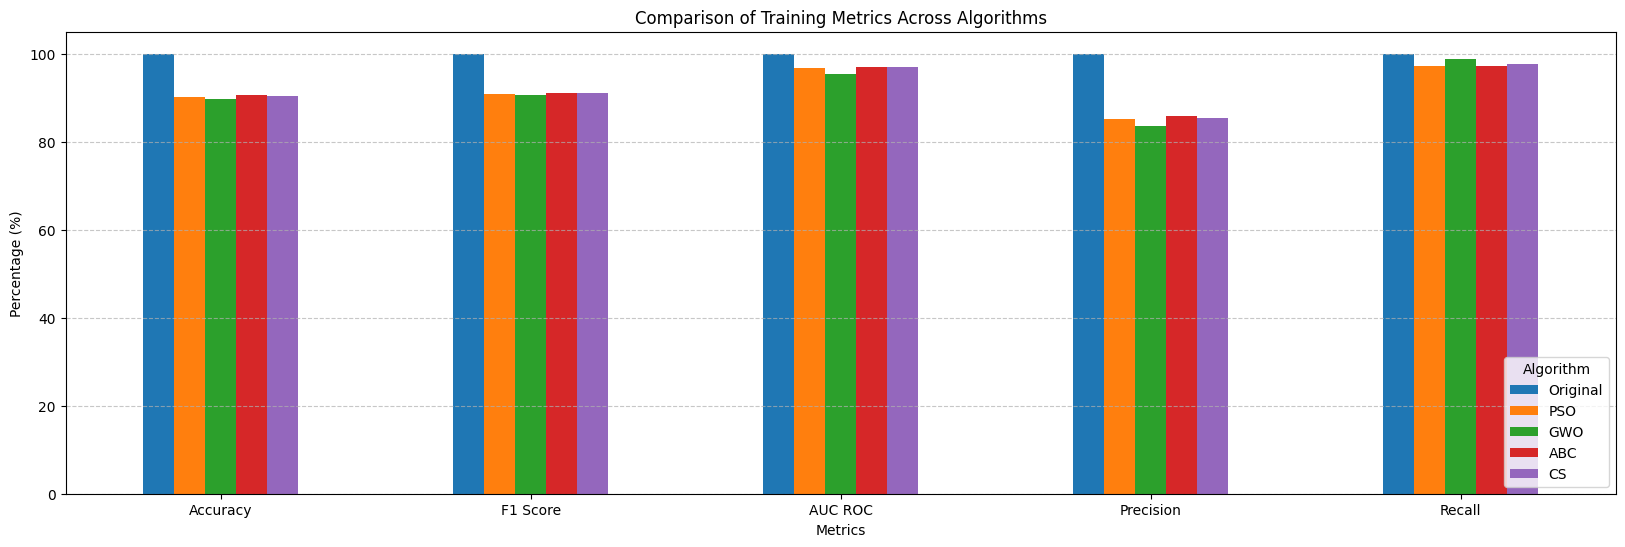

In [33]:
# Store metrics in a dictionary
metrics = {
    'Original': {
        'Accuracy': train_accuracy, 'F1 Score': train_f1, 'AUC ROC': train_auc,
        'Precision': train_precision, 'Recall': train_recall
    },
    'PSO': {
        'Accuracy': pso_train_accuracy, 'F1 Score': pso_train_f1, 'AUC ROC': pso_train_auc,
        'Precision': pso_train_precision, 'Recall': pso_train_recall
    },
    'GWO': {
        'Accuracy': gwo_train_accuracy, 'F1 Score': gwo_train_f1, 'AUC ROC': gwo_train_auc,
        'Precision': gwo_train_precision, 'Recall': gwo_train_recall
    },
    'ABC': {
        'Accuracy': abc_train_accuracy, 'F1 Score': abc_train_f1, 'AUC ROC': abc_train_auc,
        'Precision': abc_train_precision, 'Recall': abc_train_recall
    },
    'CS': {
        'Accuracy': cs_train_accuracy, 'F1 Score': cs_train_f1, 'AUC ROC': cs_train_auc,
        'Precision': cs_train_precision, 'Recall': cs_train_recall
    }
}

# Convert dictionary to DataFrame and transpose for desired format
metrics_df = pd.DataFrame(metrics) * 100  # Convert to percentage
# Print comparison table
print("\nComparison of Training Metrics Across Algorithms:")
print("Metric".ljust(12), "Original".ljust(12), "PSO".ljust(12), "GWO".ljust(12), "ABC".ljust(12), "CS".ljust(10))
print("-" * 70)
for metric in ['Accuracy', 'F1 Score', 'AUC ROC', 'Precision', 'Recall']:
    print(f"{metric.ljust(12)} {round(metrics['Original'][metric] * 100, 2):<12.2f} {round(metrics['PSO'][metric] * 100, 2):<12.2f} {round(metrics['GWO'][metric] * 100, 2):<12.2f} {round(metrics['ABC'][metric] * 100, 2):<12.2f} {round(metrics['CS'][metric] * 100, 2):.1f}")

# Plot comparison
metrics_df.plot(kind='bar', figsize=(20, 6))
plt.title("Comparison of Training Metrics Across Algorithms")
plt.ylabel("Percentage (%)")
plt.xlabel("Metrics")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.legend(title="Algorithm", loc=4)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Testing Metrices

2025-05-21 20:56:28,844 - modin.logger.default - INFO - Using sequential splitting in '.from_pandas()' because of some of the conditions are False: enough_elements=False; all_numeric_types=True; async_mode_on=False



Comparison of Testing Metrics Across Algorithms:
Metric       Original     PSO          GWO          ABC          CS        
----------------------------------------------------------------------
Accuracy     87.93        89.72        89.47        89.91        89.6
F1 Score     88.22        90.47        90.41        90.61        90.3
AUC ROC      95.59        95.51        89.41        95.63        95.5
Precision    86.75        84.82        83.51        85.28        84.9
Recall       89.74        96.93        98.56        96.64        96.5


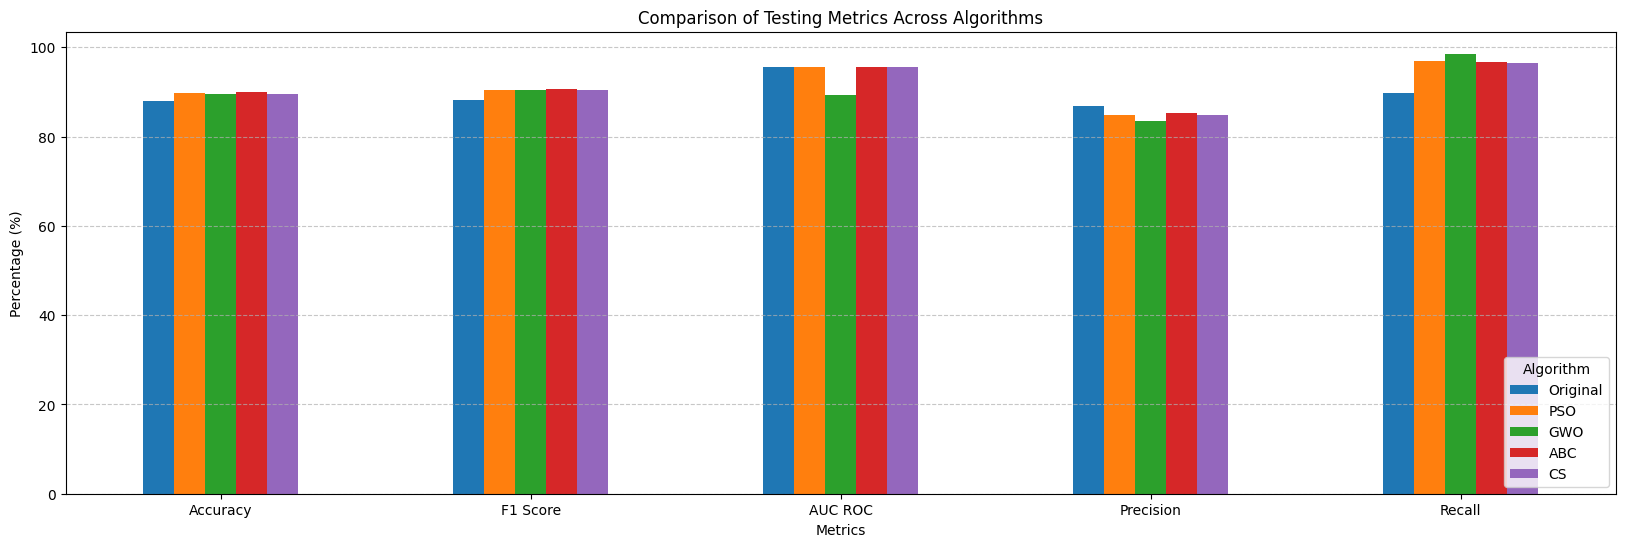

In [34]:
# Store metrics in a dictionary
metrics = {
    'Original': {
        'Accuracy': test_accuracy, 'F1 Score': test_f1, 'AUC ROC': test_auc,
        'Precision': test_precision, 'Recall': test_recall
    },
    'PSO': {
        'Accuracy': pso_test_accuracy, 'F1 Score': pso_test_f1, 'AUC ROC': pso_test_auc,
        'Precision': pso_test_precision, 'Recall': pso_test_recall
    },
    'GWO': {
        'Accuracy': gwo_test_accuracy, 'F1 Score': gwo_test_f1, 'AUC ROC': gwo_test_auc,
        'Precision': gwo_test_precision, 'Recall': gwo_test_recall
    },
    'ABC': {
        'Accuracy': abc_test_accuracy, 'F1 Score': abc_test_f1, 'AUC ROC': abc_test_auc,
        'Precision': abc_test_precision, 'Recall': abc_test_recall
    },
    'CS': {
        'Accuracy': cs_test_accuracy, 'F1 Score': cs_test_f1, 'AUC ROC': cs_test_auc,
        'Precision': cs_test_precision, 'Recall': cs_test_recall
    }
}

# Convert dictionary to DataFrame and transpose for desired format
metrics_df = pd.DataFrame(metrics) * 100  # Convert to percentage
# Print comparison table
print("\nComparison of Testing Metrics Across Algorithms:")
print("Metric".ljust(12), "Original".ljust(12), "PSO".ljust(12), "GWO".ljust(12), "ABC".ljust(12), "CS".ljust(10))
print("-" * 70)
for metric in ['Accuracy', 'F1 Score', 'AUC ROC', 'Precision', 'Recall']:
    print(f"{metric.ljust(12)} {round(metrics['Original'][metric] * 100, 2):<12.2f} {round(metrics['PSO'][metric] * 100, 2):<12.2f} {round(metrics['GWO'][metric] * 100, 2):<12.2f} {round(metrics['ABC'][metric] * 100, 2):<12.2f} {round(metrics['CS'][metric] * 100, 2):.1f}")

# Plot comparison
metrics_df.plot(kind='bar', figsize=(20, 6))
plt.title("Comparison of Testing Metrics Across Algorithms")
plt.ylabel("Percentage (%)")
plt.xlabel("Metrics")
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.legend(title="Algorithm", loc=4)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Parameters Comparision

In [35]:
# Define the parameter values
params = {
    'Original': {
        'eta': 0.3,
        'max_depth': 6,
        'subsample': 1,
        'colsample_bytree': 1,
        'alpha': 0,
        'lambda': 1,
    },
    'PSO': {
        'eta': best_pso_params[0],
        'max_depth': int(best_pso_params[1]),
        'subsample': best_pso_params[2],
        'colsample_bytree': best_pso_params[3],
        'alpha': best_pso_params[4],
        'lambda': best_pso_params[5]
    },
    'GWO': {
        'eta': best_gwo_params[0],
        'max_depth': int(best_gwo_params[1]),
        'subsample': best_gwo_params[2],
        'colsample_bytree': best_gwo_params[3],
        'alpha': best_gwo_params[4],
        'lambda': best_gwo_params[5]
    },
    'ABC': {
        'eta': best_abc_params[0],
        'max_depth': int(best_abc_params[1]),
        'subsample': best_abc_params[2],
        'colsample_bytree': best_abc_params[3],
        'alpha': best_abc_params[4],
        'lambda': best_abc_params[5]
    },
    'CS': {
        'eta': best_cs_params[0],
        'max_depth': int(best_cs_params[1]),
        'subsample': best_cs_params[2],
        'colsample_bytree': best_cs_params[3],
        'alpha': best_cs_params[4],
        'lambda': best_cs_params[5]
    }
}

# Convert dictionary to DataFrame
params_df = pd.DataFrame(params)

# Print table format
print("\nComparison of Hyperparameters Across Optimization Techniques:")
print("-" * 70)
print(params_df)

2025-05-21 20:56:29,432 - modin.logger.default - INFO - Using sequential splitting in '.from_pandas()' because of some of the conditions are False: enough_elements=False; all_numeric_types=True; async_mode_on=False



Comparison of Hyperparameters Across Optimization Techniques:
----------------------------------------------------------------------
                  Original       PSO       GWO       ABC        CS
eta                    0.3  0.136706  0.014507  0.300000  0.134131
max_depth              6.0  3.000000  4.000000  3.000000  4.000000
subsample              1.0  0.926451  1.000000  1.000000  0.938662
colsample_bytree       1.0  0.714532  1.000000  0.996736  0.694256
alpha                  0.0  5.285221  1.425961  9.247854  8.489785
lambda                 1.0  2.855483  0.185002  0.810083  6.457433
